* data shape 유지 및 xgboost 사용

In [1]:
#-*- coding: utf-8 -*-

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pandas import DataFrame, Series
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
phone_brand_device_model = pd.read_csv('data/phone_brand_device_model.csv')
gender_age_train = pd.read_csv('data/gender_age_train.csv')
label_categories = pd.read_csv('data/label_categories.csv')
events = pd.read_csv('data/events.csv')
app_labels = pd.read_csv('data/app_labels.csv')
app_events = pd.read_csv('data/app_events.csv', dtype = {'event_id' : np.int8, 'app_id' : np.int64, 
                                                   'is_installed' : np.int8, 'is_active' : np.int8})
gender_age_test = pd.read_csv('data/gender_age_test.csv')

### TimeStamp Split

In [3]:
events['timestamp'].replace('-', '', regex = True, inplace = True)
events['timestamp'].replace(':', '', regex = True, inplace = True)
events['timestamp'].replace(' ', '', regex = True, inplace = True)

events['year'] = events['timestamp'].map(lambda x: x[0:4])
events['month'] = events['timestamp'].map(lambda x: x[4:6])
events['day'] = events['timestamp'].map(lambda x: x[6:8])
events['time'] = events['timestamp'].map(lambda x: x[8:10])

events.drop(['timestamp'], axis = 1, inplace = True)
events.drop(['year'], axis = 1, inplace = True)



### 명목형 변수 치환

phone_brand_device_model.phone_brand.fillna(phone_brand_device_model.phone_brand.dropna().max(), inplace = True)
phone_brand_device_model.device_model.fillna(phone_brand_device_model.device_model.dropna().max(), inplace = True)

In [3]:
le_br = LabelEncoder()
le_mo = LabelEncoder()


phone_brand_device_model['brand'] = le_br.fit_transform(phone_brand_device_model['phone_brand'])
phone_brand_device_model['device'] = le_mo.fit_transform(phone_brand_device_model['device_model'])



phone_brand_label = phone_brand_device_model.copy()

phone_brand_label = phone_brand_label.drop('phone_brand', 1)
phone_brand_label = phone_brand_label.drop('device_model', 1)

In [4]:
#M = 1, F = 0
le_gen = LabelEncoder()
gender_age_train['M_F'] = le_gen.fit_transform(gender_age_train['gender'])

In [5]:
#group 치환
le_g = LabelEncoder()
gender_age_train['group_e'] = le_g.fit_transform(gender_age_train['group'])

### Data set 기초자료 (train + test)

In [6]:
tmp_train = pd.merge(gender_age_train, phone_brand_label, how='inner', on = 'device_id')
tmp_test = pd.merge(gender_age_test, phone_brand_label,  how='inner', on = 'device_id')

tmp_train = tmp_train.drop_duplicates(subset=['device_id'])

tmp_test = tmp_test.drop_duplicates(subset=['device_id'])

In [9]:
con = pd.concat([tmp_train, tmp_test])

tmp = pd.merge(con, events, how='left', on='device_id')

tmp = tmp[['device_id', 'age', 'M_F', 'group_e', 'brand', 'device']]

tmp = tmp.drop_duplicates(subset=['device_id'])

* 브랜드별 남녀 사용자 수
* 브랜드별 사용자 나이 분포
* 모델별 남녀 사용자 수
* 모델별 사용자 나이 분포
* 라벨별 남녀 사용자 수
* 라벨별 사용자 나이 분포

In [104]:
tmp['brand_mf'] = tmp.groupby('brand')['M_F'].apply(lambda x: x/x.sum())

tmp = tmp.drop('label_id', 1)

tmp = tmp.drop('brand_mf', 1)

tmp = tmp.drop_duplicates(subset=['device_id', 'age', 'M_F', 'group_e', 'brand', 'device'], keep='first')

In [16]:
brand_mf = pd.DataFrame()
brand_mf['count'] = tmp.groupby(['brand', 'M_F'])['M_F'].count()
brand_mf = brand_mf.reset_index()

brand_sum = brand_mf.groupby('brand')['count'].sum()
brand_mf = brand_mf.join(brand_sum, on = 'brand', rsuffix='_')
brand_mf['brand_ratio'] = brand_mf['count'] / brand_mf['count_']
brand_mf = brand_mf.drop(['count', 'count_'], 1)
brand_mf = brand_mf.set_index(['brand', 'M_F'])
brand_mf = brand_mf.unstack()

In [17]:
device_mf = pd.DataFrame()
device_mf['count'] = tmp.groupby(['device', 'M_F'])['M_F'].count()
device_mf = device_mf.reset_index()

device_sum = device_mf.groupby('device')['count'].sum()
device_mf = device_mf.join(device_sum, on = 'device', rsuffix='_')
device_mf['device_ratio'] = device_mf['count'] / device_mf['count_']
device_mf = device_mf.drop(['count', 'count_'], 1)
device_mf = device_mf.set_index(['device', 'M_F'])
device_mf = device_mf.unstack()

### label은 못씀. 편향되어 있음

label_id_mf = pd.DataFrame()
label_id_mf['count'] = tmp.groupby(['label_id', 'M_F'])['M_F'].count()

label_id_mf = label_id_mf.reset_index()

label_id_sum = label_id_mf.groupby('label_id')['count'].sum()
label_id_mf = label_id_mf.join(label_id_sum, on = 'label_id', rsuffix='_')
label_id_mf['label_id_ratio'] = label_id_mf['count'] / label_id_mf['count_']
label_id_mf = label_id_mf.drop(['count', 'count_'], 1)
label_id_mf = label_id_mf.set_index(['label_id', 'M_F'])
label_id_mf = label_id_mf.unstack()

In [18]:
brand_g = pd.DataFrame()
brand_g['count'] = tmp.groupby(['brand', 'group_e'])['group_e'].count()
brand_g = brand_g.reset_index()

brand_sum = brand_g.groupby('brand')['count'].sum()
brand_g = brand_g.join(brand_sum, on = 'brand', rsuffix='_')
brand_g['bran_g_ratio'] = brand_g['count'] / brand_g['count_']
brand_g = brand_g.drop(['count', 'count_'], 1)
brand_g = brand_g.set_index(['brand', 'group_e'])
brand_g = brand_g.unstack()

In [19]:
device_g = pd.DataFrame()
device_g['count'] = tmp.groupby(['device', 'group_e'])['group_e'].count()
device_g = device_g.reset_index()

device_sum = device_g.groupby('device')['count'].sum()
device_g = device_g.join(device_sum, on = 'device', rsuffix='_')
device_g['devi_g_ratio'] = device_g['count'] / device_g['count_']
device_g = device_g.drop(['count', 'count_'], 1)
device_g = device_g.set_index(['device', 'group_e'])
device_g = device_g.unstack()

In [20]:
brand_mf = brand_mf.reset_index()
device_mf = device_mf.reset_index()
brand_g = brand_g.reset_index()
device_g = device_g.reset_index()

In [22]:
tmp = pd.merge(tmp, brand_mf, how='left', on='brand')
tmp = pd.merge(tmp, device_mf, how='left', on='device')
tmp = pd.merge(tmp, brand_g, how='left', on='brand')
tmp = pd.merge(tmp, device_g, how='left', on='device')

C:\Python36\lib\site-packages\pandas\core\reshape\merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Python36\lib\site-packages\pandas\core\reshape\merge.py:862: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  self.right = self.right.drop(right_drop, axis=1)


In [24]:
tmp = tmp.drop(['brand_x', 'device_x'], 1)

In [25]:
tmp.head()

,device,brand,device_id,age,M_F,group_e,"('brand_ratio', 0.0)_x","('brand_ratio', 1.0)_x","('device_ratio', 0.0)_x","('device_ratio', 1.0)_x","(brand_ratio_y, 0.0)","(brand_ratio_y, 1.0)","(brand_ratio_y, 2.0)","(brand_ratio_y, 3.0)","(brand_ratio_y, 4.0)","(brand_ratio_y, 5.0)","(brand_ratio_y, 6.0)","(brand_ratio_y, 7.0)","(brand_ratio_y, 8.0)","(brand_ratio_y, 9.0)","(brand_ratio_y, 10.0)","(brand_ratio_y, 11.0)","(device_ratio_y, 0.0)","(device_ratio_y, 1.0)","(device_ratio_y, 2.0)","(device_ratio_y, 3.0)","(device_ratio_y, 4.0)","(device_ratio_y, 5.0)","(device_ratio_y, 6.0)","(device_ratio_y, 7.0)","(device_ratio_y, 8.0)","(device_ratio_y, 9.0)","(device_ratio_y, 10.0)","(device_ratio_y, 11.0)"
0,749,51,-8076087639492063270,35.0,1.0,10.0,0.342101,0.657899,0.293542,0.706458,0.05457,0.056651,0.046014,0.063356,0.06775,0.05376,0.111278,0.140817,0.079427,0.10174,0.123938,0.100699,0.031311,0.076321,0.039139,0.064579,0.046967,0.035225,0.060665,0.170254,0.113503,0.107632,0.154599,0.099804
1,749,51,-2897161552818060146,35.0,1.0,10.0,0.342101,0.657899,0.293542,0.706458,0.05457,0.056651,0.046014,0.063356,0.06775,0.05376,0.111278,0.140817,0.079427,0.10174,0.123938,0.100699,0.031311,0.076321,0.039139,0.064579,0.046967,0.035225,0.060665,0.170254,0.113503,0.107632,0.154599,0.099804
2,749,51,-8260683887967679142,35.0,1.0,10.0,0.342101,0.657899,0.293542,0.706458,0.05457,0.056651,0.046014,0.063356,0.06775,0.05376,0.111278,0.140817,0.079427,0.10174,0.123938,0.100699,0.031311,0.076321,0.039139,0.064579,0.046967,0.035225,0.060665,0.170254,0.113503,0.107632,0.154599,0.099804
3,1524,51,-4938849341048082022,30.0,1.0,9.0,0.342101,0.657899,0.377697,0.622303,0.05457,0.056651,0.046014,0.063356,0.06775,0.05376,0.111278,0.140817,0.079427,0.10174,0.123938,0.100699,0.056754,0.057418,0.041487,0.066379,0.086293,0.069366,0.086625,0.110853,0.071689,0.100232,0.130767,0.122137
4,753,51,245133531816851882,30.0,1.0,9.0,0.342101,0.657899,0.377120,0.622880,0.05457,0.056651,0.046014,0.063356,0.06775,0.05376,0.111278,0.140817,0.079427,0.10174,0.123938,0.100699,0.066551,0.074815,0.053502,0.061766,0.076120,0.044367,0.123967,0.134841,0.076990,0.099174,0.096564,0.091344


# train / test 분리

In [26]:
train = pd.merge(tmp, gender_age_train, on = 'device_id')
test = pd.merge(tmp, gender_age_test, on = 'device_id')

In [28]:
X = train.copy()

y = train.group_e_x

X = X.drop(['device_id', 'age_x','M_F_x', 'gender', 'age_y', 'group', 'M_F_y', 'group_e_y', 'group_e_x'], 1)

test_e = test.drop(['device_id', 'age', 'M_F', 'group_e'], 1)

In [39]:
X = X.fillna(X.mean())

In [40]:
test_e = test_e.fillna(test_e.mean())

## train_test_split

In [30]:
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

# Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

from matplotlib import pyplot as plt

In [33]:
forest = RandomForestClassifier(criterion = 'gini', n_estimators = 10, random_state = 1, n_jobs = -1)

In [34]:
# y_train이 2D로 되어 있어서 변경
y_train = list(y_train.values)

In [42]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

In [43]:
importance = forest.feature_importances_

In [44]:
featurename = X.columns

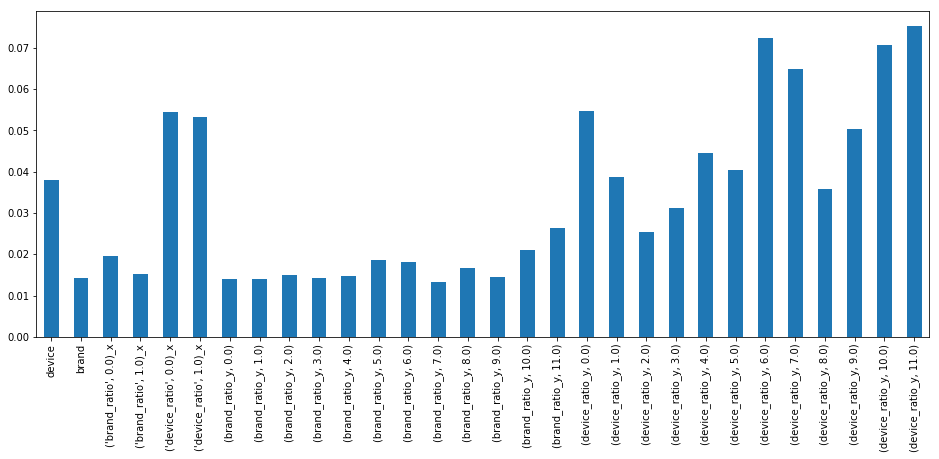

In [45]:
pd.Series(importance, index = featurename).plot(kind='bar', figsize=(16,6))

# XGBoost

In [61]:
import xgboost as xgb

In [63]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [64]:
params = {
    'objective' : 'multi:softprob',
    'num_class' : 12,
    'booster' : 'gblinear',
    'max_depth' : 10,
    'eval_metric' : 'mlogloss',
    'eta' : 0.07,
    'silent' : 1,
    'alpha' : 3
}

watchlist = [(dtrain, 'train'), (dtest, 'test')]


In [67]:
gbm = xgb.train(params, dtrain, 40, evals = watchlist, early_stopping_rounds=25, verbose_eval=True)

[0]	train-mlogloss:2.44092	test-mlogloss:2.441
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 25 rounds.
[1]	train-mlogloss:2.42602	test-mlogloss:2.42608
[2]	train-mlogloss:2.41895	test-mlogloss:2.41898
[3]	train-mlogloss:2.41436	test-mlogloss:2.41435
[4]	train-mlogloss:2.41067	test-mlogloss:2.41063
[5]	train-mlogloss:2.40739	test-mlogloss:2.40732
[6]	train-mlogloss:2.40431	test-mlogloss:2.40422
[7]	train-mlogloss:2.40141	test-mlogloss:2.4013
[8]	train-mlogloss:2.39866	test-mlogloss:2.39854
[9]	train-mlogloss:2.39604	test-mlogloss:2.3959
[10]	train-mlogloss:2.39354	test-mlogloss:2.39339
[11]	train-mlogloss:2.39116	test-mlogloss:2.391
[12]	train-mlogloss:2.3889	test-mlogloss:2.38872
[13]	train-mlogloss:2.38673	test-mlogloss:2.38655
[14]	train-mlogloss:2.38467	test-mlogloss:2.38447
[15]	train-mlogloss:2.38269	test-mlogloss:2.38249
[16]	train-mlogloss:2.38081	test-mlogloss:2.38059
[17]	train-mlogl

In [68]:
y_pred = gbm.predict(xgb.DMatrix(test_e))

In [69]:
result = pd.DataFrame(y_pred, columns = le_g.classes_)
result['device_id'] = device_id
result = result.set_index('device_id')
result.to_csv('xg_sun.csv')